# NBA SHOT LOGS

## The Dataset

The dataset contains info on shots taken during the 2014-2015 NBA season, with columns displaying who took the shot, where on the court was the shot taken from, nearest defender, etc. There are 21 columns in total and 128069 observations.

The data was found on https://www.kaggle.com/dansbecker/nba-shot-logs, but originally scraped from NBA's REST API.


### Columns

There are 21 columns in total:
1.	GAME_ID: the ID of the game on the NBA website.
2.	MATCHUP: Date and the two teams' abbreviated names.
3.	LOCATION: A (away) or H (home), from the shot taker's perspective.
4.	W: W (win) or L (loss), from the shot taker's perspective.
5.	FINAL_MARGIN: Point differential between the two teams at the end of regulation.
6.	SHOT_NUMBER: Number of the shot taken by that player during the game.
7.	PERIOD: Which period the shot was taken at.
8.	GAME_CLOCK: Game time played until the moment of the shot.
9.	SHOT_CLOCK: Seconds into the shot clock when the shot was taken (time allotted by the shot clock in the NBA is 24s).
10.	DRIBBLES: How many dribbles taken before the shot.
11.	TOUCH_TIME: Time with the ball before taking the shot.
12.	SHOT_DIST: How far the shot is from the basket (measured in feet).
13.	PTS_TYPE: 2 or 3 (depends on whether the shot was taken inside or outside the 3-point line).
14.	SHOT_RESULT: made/missed.
15.	CLOSEST_DEFENDER: Name of the closest defender.
16.	CLOSEST_DEFENDER_PLAYER_ID: Id of the closest defender.
17.	CLOSE_DEF_DIST: Distance of the closest defender from the shot taker.
18.	FGM: Field goals made until that shot by that player.
19.	PTS: How many points the player had until that shot.
20.	player_name: Name of the player taking the shot
21.	player_id: Shot taker ID


## Data prep/cleaning process

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight')

In [2]:
# import data
df = pd.read_csv("shot_logs.csv")

First thing that was done was to check the type of each column:

In [3]:
df.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

The only column that needs to be changed is the GAME_CLOCK column (originally an object type) to number of SECONDS after the game started so it can be used as a measure during the data analysis. 

In [4]:
#Turns object into datetime64 type then into number of seconds
df['GAME_CLOCK'] = (pd.to_datetime(df['GAME_CLOCK'], format="%M:%S") - pd.to_datetime('1900-01-01')).dt.total_seconds()

Here are the first 5 observations of the dataset: 

In [5]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,69.0,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,14.0,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0.0,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,707.0,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,634.0,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## Simple Statistics

### Layups, jumpers, threes and their expected value

Start by computing the league averages for layups (shots less than 5 ft from the basket), jumpers (between 5 and 22), and three pointers (more than 22 ft from the basket).

In [6]:
layups = len(df[(df.SHOT_DIST <= 5) & (df.SHOT_RESULT == 'made')]) / len(df[(df.SHOT_DIST <= 5)])
jumpers = len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22) & (df.SHOT_RESULT == 'made')]) / len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22)])
threes = len(df[(df.SHOT_DIST > 22) & (df.SHOT_RESULT == 'made')]) / len(df[(df.SHOT_DIST > 22)])
print('LAYUPS: ', round(layups*100, 2), "%")
print('JUMPERS: ', round(jumpers*100, 2), "%")
print('THREES: ', round(threes*100, 2), "%")

LAYUPS:  61.65 %
JUMPERS:  41.58 %
THREES:  35.11 %


Looking at these averages, it coincides with Houston Rocket's head coach Mike D'Antoni´s system (that prioritizes layups and three pointers), to make the offense more efficient. This is evident considering the value per shot. For layups, we can expect 1.233 points (0.6165 * 2) per attempt, and for threes we can expect 1.0533 per attempt; whereas long jumpers and floaters will only have an expected value of 0.83 per attempt.

### In the Clutch

In this part of the project, the goal was to study how the shot percentage changes during clutch time (in this analysis clutch time will be considered as the last 5 minutes of regulation, and the final margin is less than 5 points). We will start by comparing the averages for the three types of shots mentioned earlier during the last 5 minutes to their usual percentage. 

In [7]:
# The last 5 minutes corresponds to a game clock after 300 seconds in period number 4
clutch_time = (df.PERIOD == 4) & (df.GAME_CLOCK >300) & (df.FINAL_MARGIN <= 5) & (df.FINAL_MARGIN >= -5)
clutch_layups = len(df[(df.SHOT_DIST <= 5) & (df.SHOT_RESULT == 'made') & clutch_time]) / len(df[(df.SHOT_DIST <= 5) & clutch_time])
clutch_jumpers = len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22) & (df.SHOT_RESULT == 'made') & clutch_time]) / len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22) & clutch_time])
clutch_threes = len(df[(df.SHOT_DIST > 22) & (df.SHOT_RESULT == 'made') & clutch_time]) / len(df[(df.SHOT_DIST > 22) & clutch_time])
print('LAYUPS IN THE CLUTCH: ', round(clutch_layups*100, 2), "%")
print('JUMPERS IN THE CLUTCH: ', round(clutch_jumpers*100, 2), "%")
print('THREES IN THE CLUTCH: ', round(clutch_threes*100, 2), "%")


LAYUPS IN THE CLUTCH:  62.62 %
JUMPERS IN THE CLUTCH:  40.12 %
THREES IN THE CLUTCH:  35.15 %


From the results above, we can conclude that there isn't a significant change in percentages during the last 5 minutes of a close basketball game.

The next step is to check if there is a change in shot creation (difference in the amount of a type of shot during clutch time). Usually, teams 'lock up' in close games, not allowing easier shots (layups).

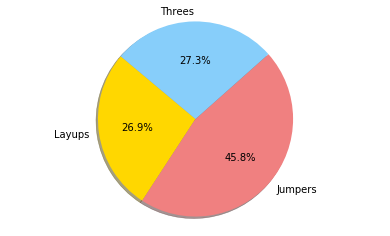

In [8]:
n_layups = len(df[(df.SHOT_DIST <= 5)])
n_jumpers = len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22)])
n_threes = len(df[(df.SHOT_DIST > 22)])

n_layups_clutch = len(df[(df.SHOT_DIST <= 5) & clutch_time])
n_jumpers_clutch = len(df[(df.SHOT_DIST > 5) & (df.SHOT_DIST <= 22) & clutch_time])
n_threes_clutch = len(df[(df.SHOT_DIST > 22) & clutch_time])

# Data to plot
labels = 'Layups', 'Jumpers', 'Threes'
sizes = [n_layups, n_jumpers, n_threes]
colors = ['gold', 'lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Now the share for shot creation on clutch time are as follows:

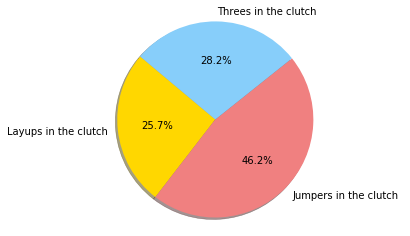

In [9]:
# Data to plot
labels = 'Layups in the clutch', 'Jumpers in the clutch', 'Threes in the clutch'
sizes = [n_layups_clutch, n_jumpers_clutch, n_threes_clutch]
colors = ['gold', 'lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

As shown on the pie chart above, we see a slight decrease of layups, along with an increase on both three pointers and jumpers.

Next, I'd like to explore the average distance of the defender during the game, compared to when the game is close. Naturally, it would make sense for players to put more effort on defense later on during the game when the score is close. 

In [16]:
avg_def_dist = np.average((df.CLOSE_DEF_DIST))
avg_def_dist_clutch = np.average(df[clutch_time].CLOSE_DEF_DIST)

print("Average defender distance is ", round(avg_def_dist,2), "ft")
print("Average defender distance in the clutch is ", round(avg_def_dist_clutch,2), "ft")

Average defender distance is  4.12 ft
Average defender distance in the clutch is  4.03 ft


Again, we see a slight difference when it comes to the end of the game. 